# Use Case Complex Images : Aptos

**Introduction:**

Welcome to HES-Xplain, our interactive platform designed to facilitate explainable artificial intelligence (XAI) techniques. In this use case, we dive into sport image classification and showcase the utility of eXplainable AI (XAI) in this domain. We will focus on applying tools available on our platform to interpret and understand the decisions made by a Convolutional Neural Network (CNN) model.

We also provide scripts, conveniently customizable, facilitate data loading, model training and evaluation, and performance metric plotting. Located in the scripts folder of this repository, they feature clear annotations to aid comprehension and instructions for effortless adaptation to your specific model needs.

We will go through some state of the art XAI techniques for CNN models and some tools that wer designed by our team such as Rules Extraction or Fuzzy Logic. To do this we will use a pre-trained model, a diabetic retinopathy detection dataset, and HES-XPLAIN to interpret the model's predictions.

**Objectives:**

1. Understand the importance of interpretability in image classification.
2. Introduce XAI techniques to interpret classification and understand a CNN model.
3. Showcase the capabilities of HES-XPLAIN. 
4. Provide practical insights into applying such techniques through an interactive notebook.
5. Foster a community of XAI enthusiasts and practitioners.

**Outline:**

1. Dataset and Problem Statement.
2. Model Architecture.
3. Modeling, training, and evaluation.


## Google Colab Setup

This section prepares the notebook for use with Google Colaboratory. If applicable, change the following variable to **True**:

In [1]:
# Colab compatibility
use_colab = False

Prepare the code by downloading the code and installing required packages.

In [2]:
if use_colab:
    # ensure the directory is empty
    !rm -rf * .config

    !# install codebase from GitHub
    !git clone --no-checkout https://github.com/HES-XPLAIN/notebooks.git --depth=1 .
    !git config core.sparseCheckout true
    !git sparse-checkout set --cone
    !git sparse-checkout add use_case_sport_classification
    !git sparse-checkout reapply
    !git checkout main

    # adjust folder structure
    !mv use_case_aptos/* .
    !rm -rf use_case_aptos/

In [3]:
if use_colab:
    # Install dependencies
    !pip install omnixai-community

When asked to, restart the session by clicking on the "Restart Session" button, then continue and execute the next cells.

## Workspace Setup

This section download the required code and models from our GitHub and huggingface.co repositories.

Download the model weight.

In [4]:
!mkdir -p models_weight
!curl -L https://huggingface.co/HES-XPLAIN/VGGAptos/resolve/main/VGGAptos_1908_v2.pth -o VGGAptos.pth
!curl -L https://huggingface.co/HES-XPLAIN/VGGAptos/resolve/main/VGG_augmented_1908_v2.pth -o VGGAptos_augmented.pth
!mv *.pth models_weight/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1139  100  1139    0     0   5602      0 --:--:-- --:--:-- --:--:--  5583
100  512M  100  512M    0     0  96.6M      0  0:00:05  0:00:05 --:--:--  101M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1153  100  1153    0     0   7256      0 --:--:-- --:--:-- --:--:--  7297
100  512M  100  512M    0     0  87.1M      0  0:00:05  0:00:05 --:--:-- 85.6M


---
## Dataset and Problem Statement

The APTOS 2019 retina classification dataset utilized in this use case comprises approximately 3,662 images, encompassing a range of severity levels for diabetic retinopathy. This dataset, accessible on [Kaggle](https://www.kaggle.com/competitions/aptos2019-blindness-detection/), includes a total of 3,662 images, which are categorized into five severity levels of diabetic retinopathy (DR).
The five classification categories are : 
- No DR
- Mild
- Moderate
- Server
- Proliferative DR

**Problem Statement:** The goal is to develop a reliable image classifier capable of accurately diagnosing the severity of diabetic retinopathy from retina images. The dataset's focus on varying stages of this condition makes it ideal for applying and demonstrating XAI techniques. By employing deep learning models and XAI techniques, the objective is not only to achieve superior classification accuracy but also to understand the key regions within the retina images that influence the classification decisions.

In [5]:
# global imports
import json
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms

from omnixai_community.data.image import Image as omniImage
from omnixai_community.explainers.vision import VisionExplainer
from omnixai_community.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM, GradCAMPlus
from omnixai_community.preprocessing.image import Resize

from scripts.helpers import *
from scripts.model import VGGAptos

In [6]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [7]:
# set global variables

home_path = "./"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

idx2class = {
    0: 'No DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferative DR'
}

class2idx = {
    'No DR': 0,
    'Mild': 1,
    'Moderate': 2,
    'Severe': 3,
    'Proliferative DR': 4
}

class_names = list(class2idx.keys())

### Load the Model

In this use case, we leverage the power of transfer learning and fine-tuning by utilizing a pre-trained model. Specifically, we will be using a fine-tuned VGG model that have already learned valuable features from a large-scale dataset. To perform inference with this model, we will need to include the model class definition script.

**Class Definition Script:**

You can find the class definition script (`model.py`) in the `scripts` directory of this notebook that define a VGG model. You can create a similar class with the model of your needs,  just make sure to adapt it to the number of classes of your dataset, here it is 5 classes. 

The script contains the necessary custom class definitions and functions required for the sport image classification task. Make sure to include and import this script in your code to ensure proper model instantiation and inference.

To load the fine-tuned weights into the model, you can use the following code snippet:

```python
import torch
from scripts.model import YourCustomModelClass

# Create an instance of your PyTorch model
model = YourCustomModelClass()

# Load the fine-tuned weights into the model
model.load_state_dict(torch.load("path_to_your_fine_tuned_weights.pth"))

# Set the model to evaluation mode
model.eval()

# Perform inference using the model
# ...

In [8]:
from scripts.model import VGGAptos

model = VGGAptos(mode='evaluation')
model.load_state_dict(torch.load('./models_weight/VGGAptos.pth',  map_location=device))

<All keys matched successfully>

### Model Architecture

For now, we will utilize the VGG16 architecture, which has demonstrated excellent performance in image classification tasks. VGG16 models are known for their simplicity and effectiveness, making them widely used in various computer vision applications.

VGG16 consists of several convolutional layers followed by fully connected layers. The architecture is characterized by its deep stack of convolutional layers, which allows it to learn complex features from input images.

In our case, we will use the VGG16 model with the following specifications:

- Model: VGG16
- Pretrained: Yes
- Number of classes: 100

VGG16 is a well-established model in the computer vision community and has been pretrained on large-scale image datasets like ImageNet. By leveraging transfer learning and fine-tuning, we can utilize the pre-trained weights of VGG16 to enhance our model's performance on the sport image classification task.

In [9]:
model

VGGAptos(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

### Traininig

As previously described, we've loaded a pretrained model that underwent fine-tuning. However, if desired, you have the option to further fine-tune it using either our train scripts or the train functions provided, both defined in ./scripts/train.py. As we can't direclty provide an access to the dataset you will need to download the APTOS 2019 dataset and place it in a folder /data to match the script requirements before using it. 

In [10]:
# TO DO

# using the script 
#!python scripts/train.py --epochs 100 --lr 1e-4 --name CustomName

# or using the function 
# from scripts.train
# and use it as you needs

### Evaluation

To evaluate the performance of the model on the evaluation dataset, let's have a look at the pre-computed confusion matrix and see what is interesing. Once again you can compute it yourself alone or using the functions given in the scripts/helpers.py file. Here we plot a pre-computed matrix since we can not provide the test set directly. 

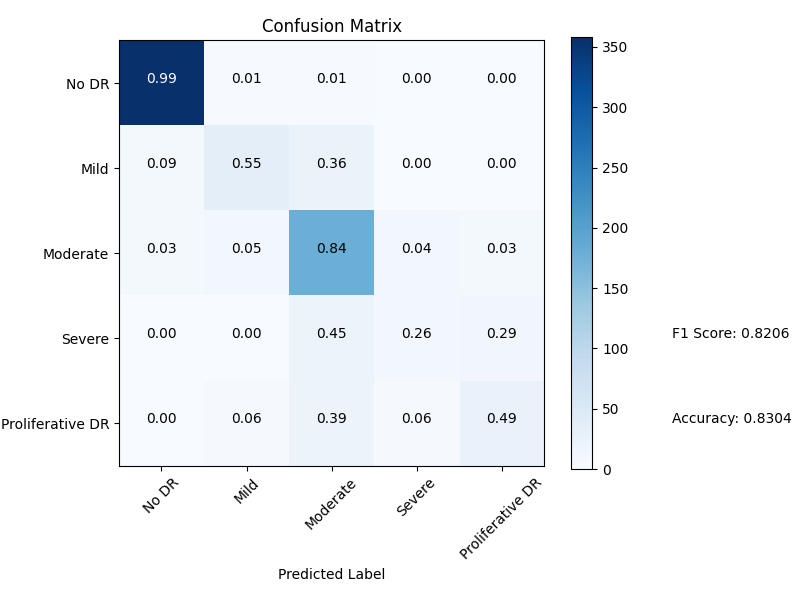

In [11]:
from PIL import Image

# Open and display the image
img = Image.open('plots/confusion_matrixVGGAptos_1908_v2.png')
img


#### Understanding the Confusion Matrix: A Case Study

In our confusion matrix, we notice that the "No DR" category is classified very accurately, with more than 99% of samples correctly identified. This high accuracy is likely because "No DR" is a clear and dominant category in our dataset. 

However, we observe that the other categories, like "Moderate DR," "Mild DR," "Severe DR," and "Proliferative DR," show varied levels of accuracy. For example:

- "Moderate DR" has a reasonable accuracy of about 0.84.
- "Severe" shows a very bad accuracy of 0.26.

What’s particularly surprising is that the model seems to mistakenly classify many samples as "Moderate DR," even when they belong to "Mild," "Severe," or "Proliferative DR." Specifically, 36% of "Mild" samples and 45% of "Severe" samples are misclassified as "Moderate." This is a notable issue.

Looking at the number of samples in the original dataset (see the plot below) we find that the "Moderate" category is overrepresented compared to the other categories, except "No DR." This overrepresentation might explain why the model tends to favor the "Moderate DR" classification.


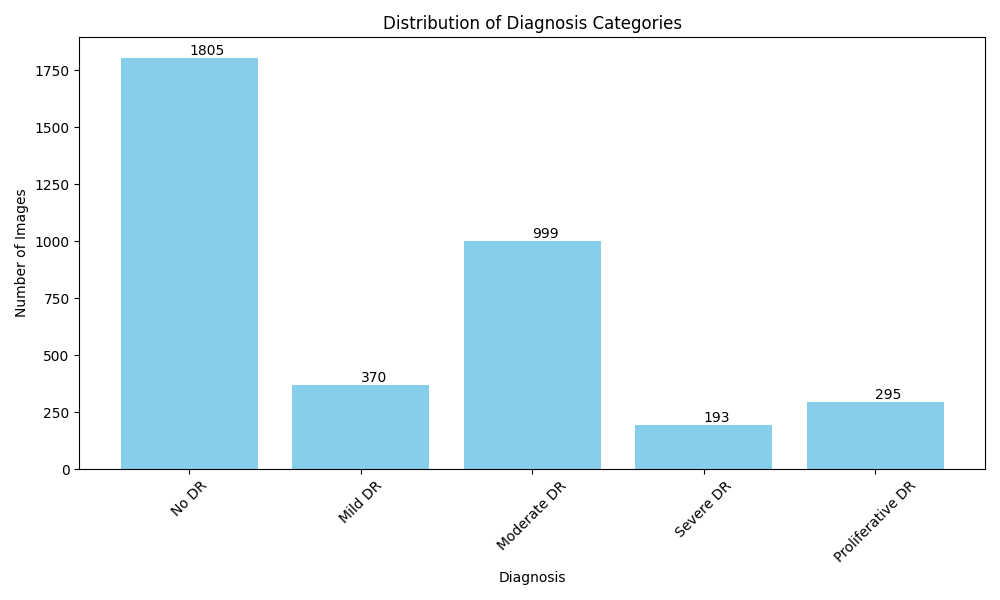

In [12]:
# Open and display the image
img = Image.open('plots/bar_plot_classname.png')
img


To improve our model, we can retrain it with adjustments for these dataset imbalances in order to remove this sampling bias. 
To do this we randomly selected No DR to select only 1k images and using random image transformations we increase the number of samples per catergory to reach 1k as shown below. 

Additionally, we can use Explainable AI (XAI) techniques to better understand where the model is making mistakes and why. This approach will help us enhance the model's performance and make it more accurate across all categories.

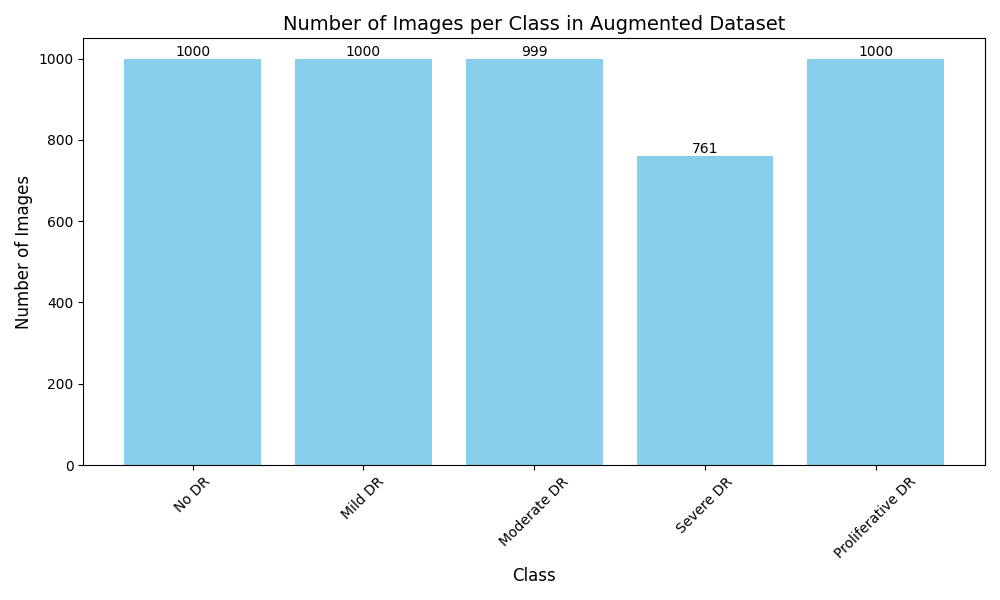

In [13]:
img = Image.open('plots/bar_plot_classname_balanced.png')
img

### Balancing the dataset 

Now we can use this balanced dataset to fine tune our VGG model. And hopefully we will get rid of most effect due to imbalance data.

In [14]:
model_balanced = VGGAptos(mode='evaluation')
model_balanced.load_state_dict(torch.load('./models_weight/VGGAptos_augmented.pth'))

<All keys matched successfully>

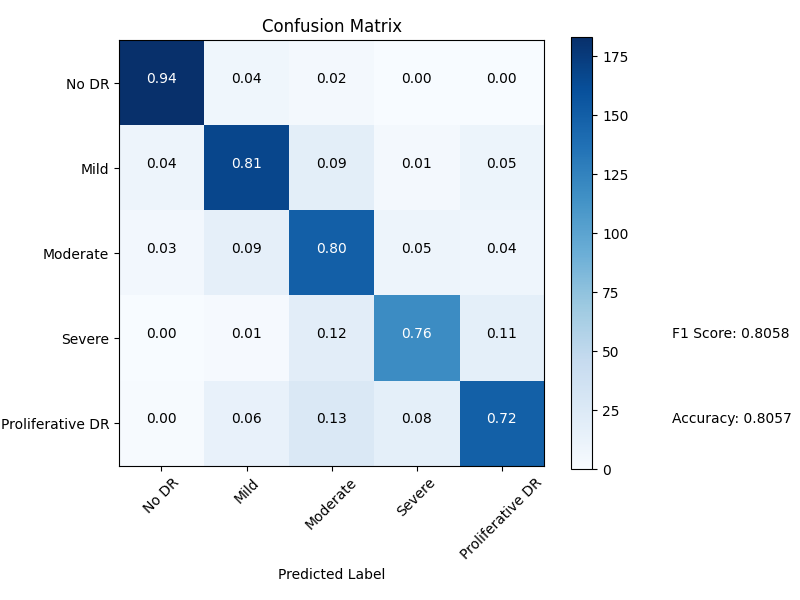

In [15]:
# Open and display the image
img = Image.open('plots/confusion_matrixVGG_augmented_1908_v2.png')
img


#### Model Evaluation and Next Steps

After retraining our model on a balanced dataset, we observed some interesting results:

- **F1 Score and Accuracy**: While the overall F1 score and accuracy haven't improved significantly and eveng get slightly worse, the confusion matrix shows a noticeable improvement. Now, all categories are classified with an accuracy of more than 0.72.
- **Category-Specific Performance**: There is a slight 4% drop in the accuracy for the "No DR" category. However, this decrease is offset by improvements in the accuracy of other categories.
- **Current Model Status**: Our model, trained on a balanced dataset, now provides more consistent and coherent classifications across different categories.

Despite these improvements, there are still instances of incorrect classifications. To further enhance our model and understand its behavior better, the next step is to use Explainable AI (XAI) techniques. XAI will help us:

1. **Make the Model More Understandable**: By using XAI, we can gain insights into how the model makes decisions.
2. **Identify Potential Biases**: XAI can also help us spot any remaining biases or issues in the model.

This approach will guide us in refining the model further and ensuring its predictions are as accurate and fair as possible.

---
Looking into the confusion matrix we can see that the worse classified category is "proliferative DR" which could be problematic since it is the worse condition category. We can see that 13% of the Profliferative DR are predicted as Moderate which is surprising because they are not neighbours category, let's try to find out what our model is doing wrong here. 

---

## XAI methods

### Class Activation Maps

In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims]).to(device)
postprocess = lambda logits: torch.nn.functional.softmax(logits, dim=1)   

explainer = GradCAM(
    model=model_balanced,
    target_layer=model_balanced.features[-4],
    preprocess_function=preprocess
)


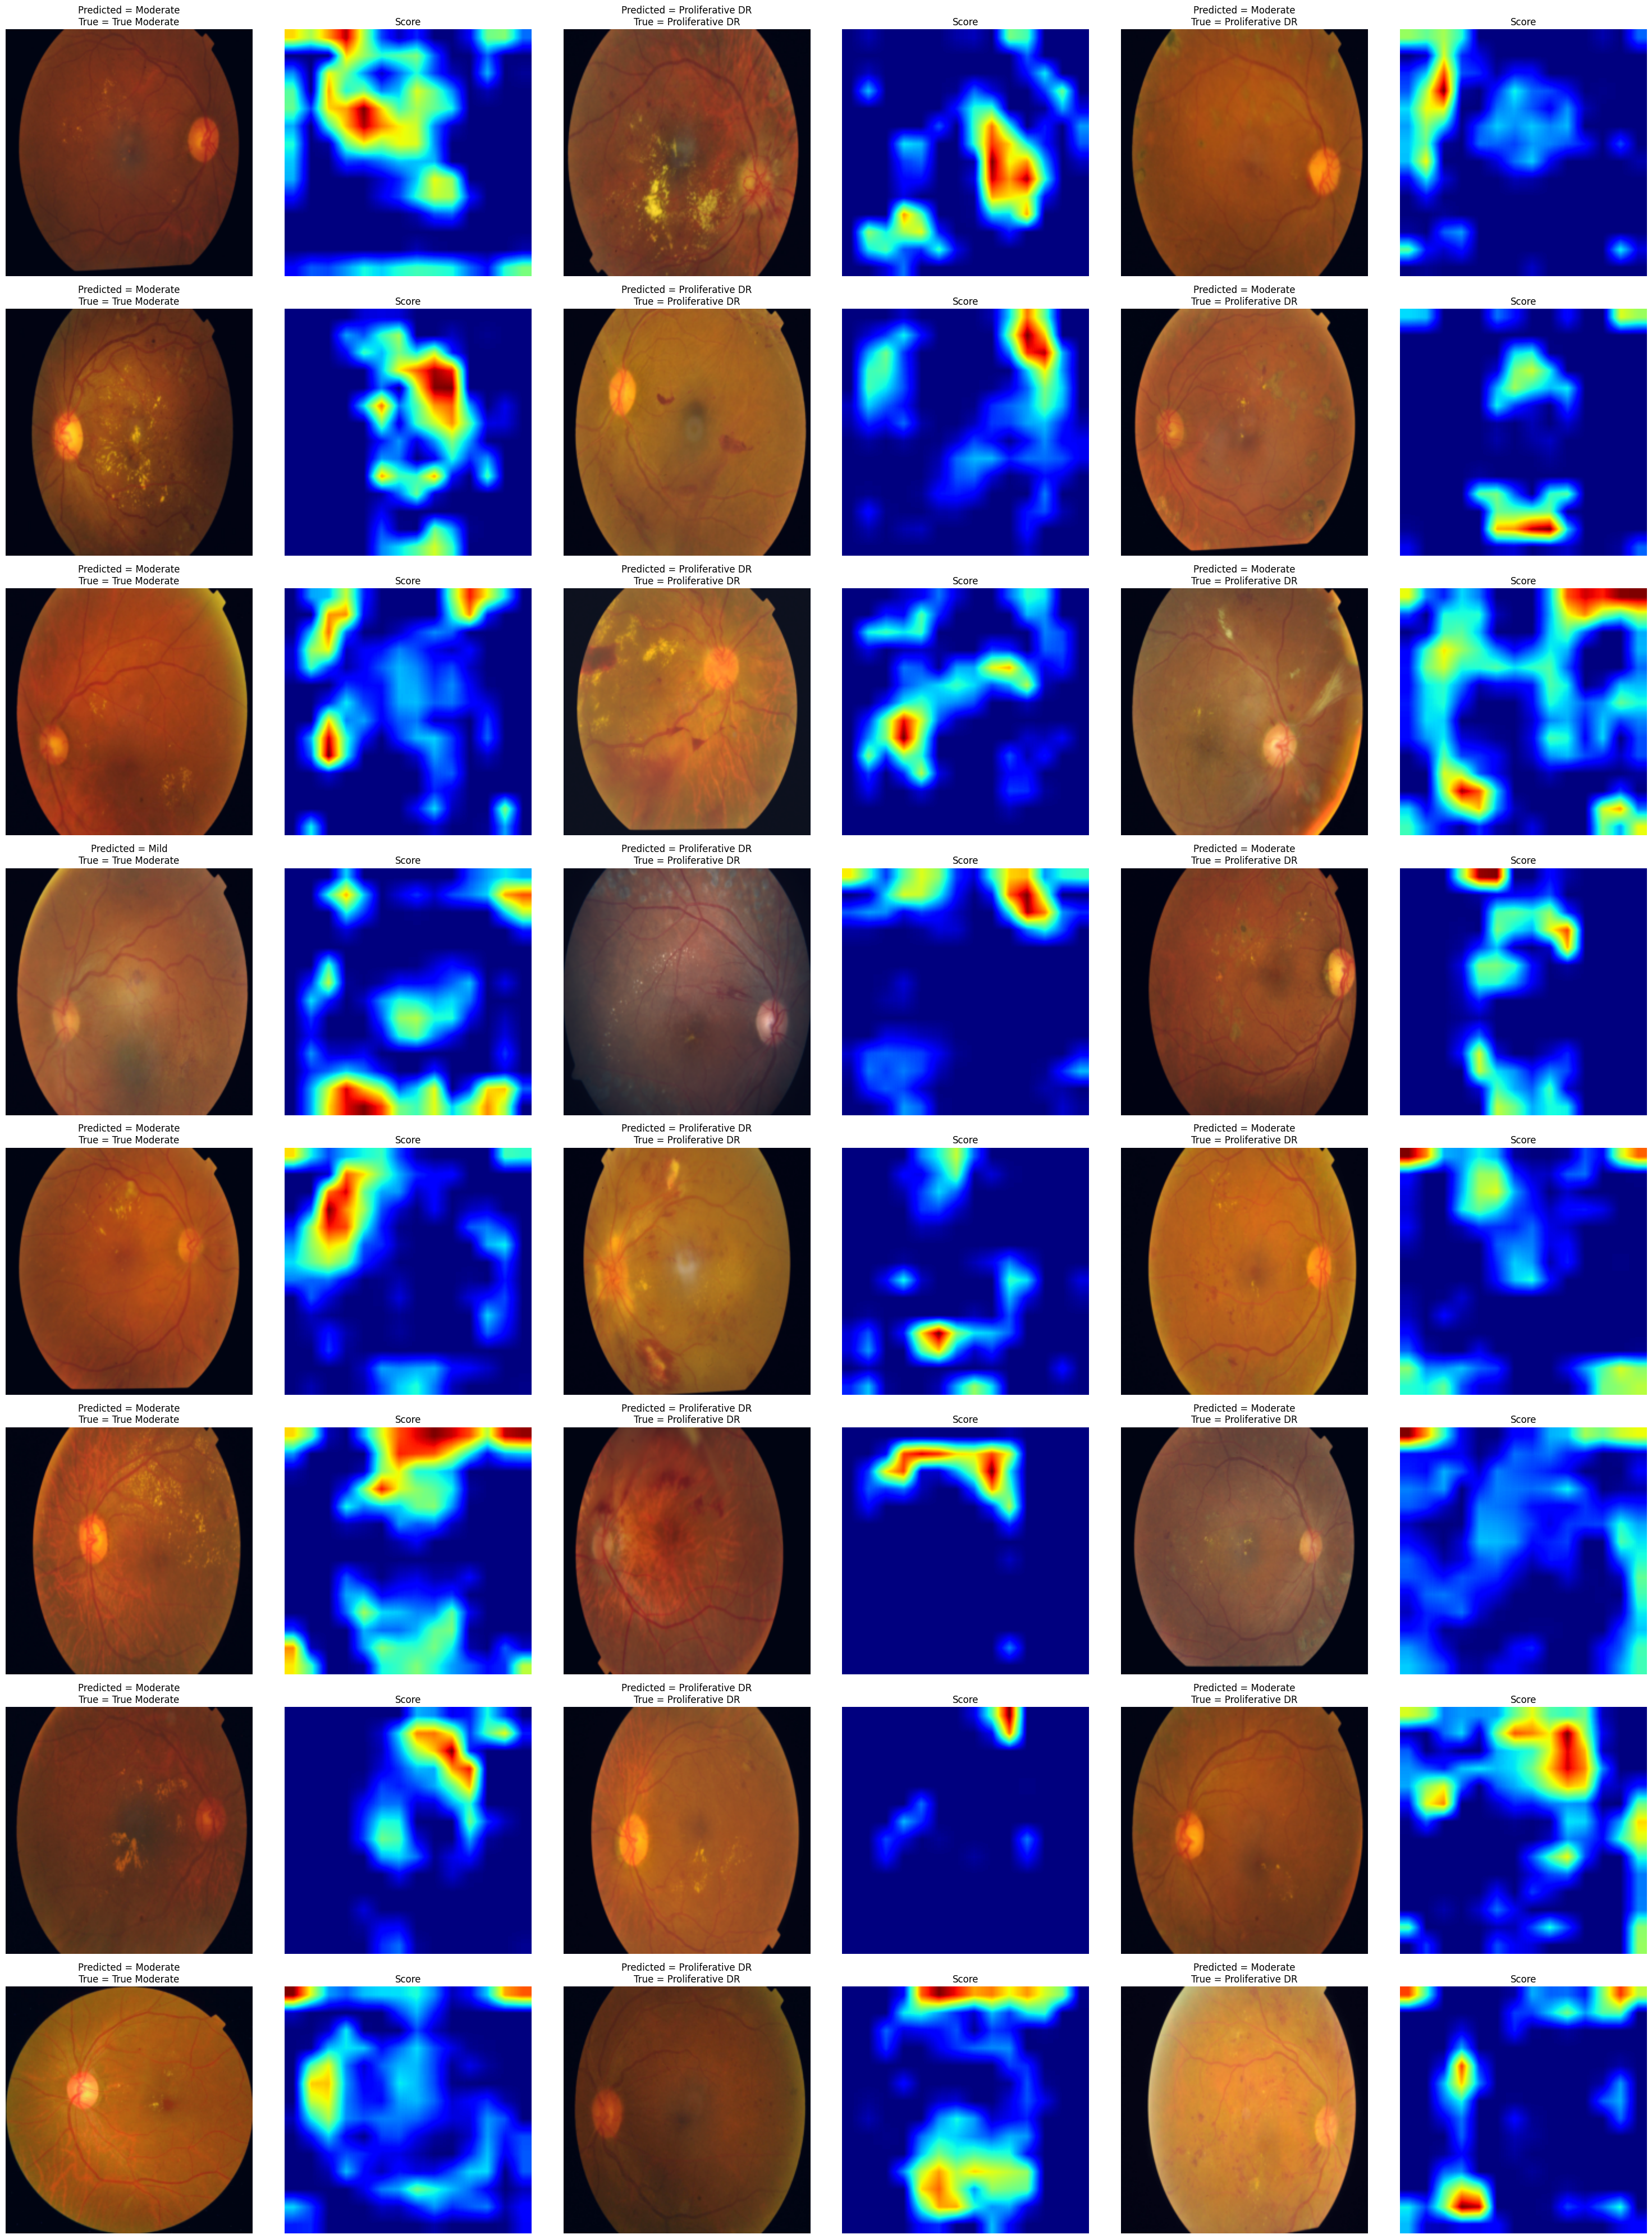

In [17]:
fig, axes = plt.subplots(8, 6, figsize=(30, 40))

true_moderate_paths = select_random_images('./data/moderate', num_images=8)
proliferative_dr_paths = select_random_images('./data/proliferative', num_images=8)
false_moderate_paths = select_random_images('./data/pro_pred_as_mod', num_images=8)

for i, img_path in enumerate(true_moderate_paths):
    plot_image_and_score(explainer, axes[i, 0], axes[i, 1], img_path, idx2class, class2idx, true_label="True Moderate")

for i, img_path in enumerate(proliferative_dr_paths):
    plot_image_and_score(explainer, axes[i, 2], axes[i, 3], img_path, idx2class, class2idx, true_label="Proliferative DR")


for i, img_path in enumerate(false_moderate_paths):
    plot_image_and_score(explainer, axes[i, 4], axes[i, 5], img_path, idx2class, class2idx, true_label="Proliferative DR")

plt.tight_layout()
plt.savefig("gradcam_comparison.png", dpi=300)
plt.show()

#### Identifying bias and improving the model

Looking at the images and heatmap above we can see three different cases : well classified moderate images, well classified proliferative images and Proliferative images that are wrongly classified as moderate. 

Class activation maps can be used to help an expert to understand the model decision, but we are not expert in ophtalmology so it is difficult for us to understand the heatmap and link it to the image. However as data scientist we can use this gradcam to understand the model and its predictions. 

We can see that in the wrong classification casees the model seems to focus on part of images that lack information as the top left corner for example. This is a potential flaw of the model, it should not focus on this part of the image to make a decision. 

To avoid this we can adapt our preprocessing, we can for instance during training use a center crop operation to remove corner and force the model to look at the center of the image. 

---

---
### Rules Extraction

Rules extraction is a technique used to extract rules from a CNN's last convolutional layer. It computes the average features of the convolutional layer and extract undersandable rules from it preserving the model perfromance while being more interpretable. 

Next we will use the rules-extraction library to create a simple rule based model to classify images, this will allow us to understand which features are important for the model to make a decision and to see if we can improve the model accuracy with a simpler model. 

Rules extractions classifiy one target class versus the others, so we have one model for each class.

---
To avoid large computation time we pre-computed the average features of the filtered dataloaders. This features are stored in features_map_train and features_map_test, they are loaded using the compute_avg_features function that will try to find a csv at csv_path to avoid computing

To do the computing on your side, on the compute_avg_features function you can simply modify the use_existing parameter to False and add the model, loader, idx_to_names, device and csv_path parameters like this :

```python
train_features = compute_avg_features(model, train_loader, idx_to_names, device, use_existing=False, csv_path='./features_map_train.csv')
test_features = compute_avg_features(model, test_loader, idx_to_names, device, use_existing=False, csv_path='./features_map_test.csv')

In [18]:
from rules_extraction.utils import compute_avg_features, make_target_df, extract_all_rules
from rules_extraction.rules import Rule, EnsembleRule, RuleRanker

In [19]:
# extract of .csv or .zip for train because file is > 100mb
if os.path.exists('data/features_map_train.csv'):
    train_features = compute_avg_features(use_existing=True, csv_path='data/features_map_train.csv')
elif os.path.exists('data/features_map_train.zip'):
    import zipfile
    with zipfile.ZipFile('./features_map_train.zip', 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname('./features_map_train.csv'))
    train_features = compute_avg_features(use_existing=True, csv_path='data/features_map_train.csv')

# test
test_features = compute_avg_features(use_existing=True, csv_path='data/features_map_test.csv')


Loading existing features from data/features_map_train.csv


Loading existing features from data/features_map_test.csv


train_features and test_features are the computed average features for all classes. To use rules extraction we need to use one target class versus the others. So we need to extract the features for each class versus the others and then train a rule extraction model for this class. To do this we can use the make_target_df function that will create a balance dataset for the target class.

Let's focus on the 'No DR' class and use extract_all_rules to extract the rules for this class. Finally we can rank them using the RuleRanker module. 

In [20]:
target_class = 'No DR'
df_train = make_target_df(train_features, target_class)
df_test = make_target_df(test_features, target_class)

X_train, y_train = df_train.iloc[:, :-3], df_train.iloc[:, -1]
X_test, y_test = df_test.iloc[:, :-3], df_test.iloc[:, -1]

all_rules = extract_all_rules(X_train, y_train, n_estimators=200, max_depth=2, random_state=1)
top_30_rules = RuleRanker(all_rules, X_train, y_train).rank_rules(N=30)

In [21]:
# Extract conditions and labels from the list and initialize a list of Rule
conditions_list, labels_list = zip(*top_30_rules)
rules = [Rule(conditions, label) for conditions, label in zip(conditions_list, labels_list)]

# Initialize ensemble rule
ensemble_rule = EnsembleRule(rules)

# Predict with ensemble rule
data_point = df_test.iloc[0]
ensemble_prediction = ensemble_rule.predict(data_point)
print(f"Ensemble Rule Prediction: {ensemble_prediction[0]} the correct prediction is {data_point['binary_label']}")

# predict on the test set
ensemble_predictions = ensemble_rule.predict(X_test)
print(f"Accuracy on test set: {ensemble_rule.score(X_test, y_test):.3f}")

Ensemble Rule Prediction: 1 the correct prediction is 1
Accuracy on test set: 0.921


We can see that the accuracy is quite good, almost 93%. This is achieve using simple rules that can be easily understood. 

Let's plot the accuracy of the rules on the train and test set. 

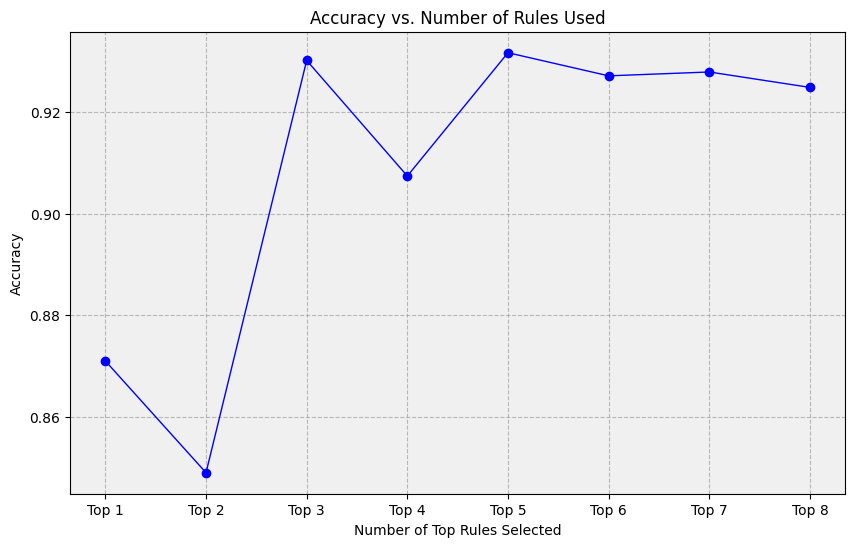

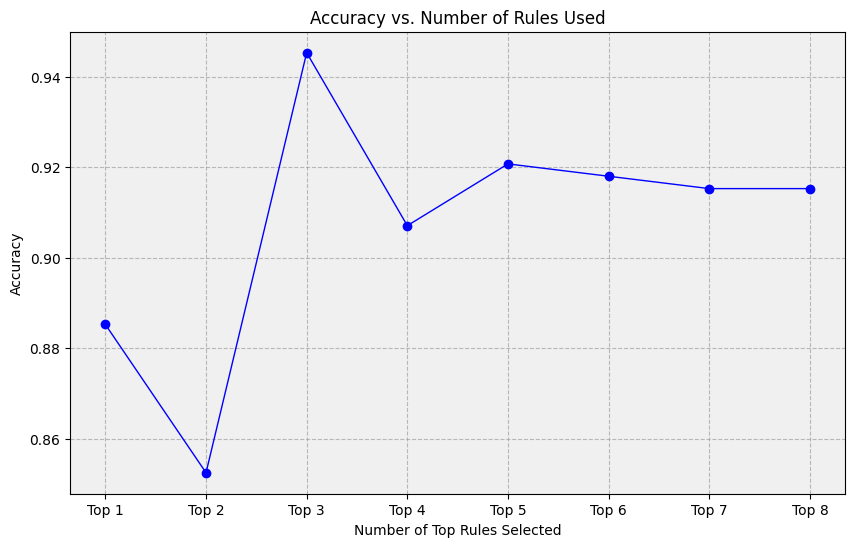

In [22]:
from rules_extraction.rules import Rule, EnsembleRule, RuleRanker
from rules_extraction.plot import plot_accuracy, plot_frontier
from rules_extraction.utils import *

plot_accuracy(rules, df_train, class_name=None, n=9, save_path=None)
plot_accuracy(rules, df_test, class_name=None, n=9, save_path=None)

We can see that using only 3 rules we get a good accuracy on the test set. This is a simple model that can be easily understood and used to classify images. 

To illustrat let's see the top 3 rules that are used to classify the images and reach 93% accuracy. 

In [23]:
# Usage
target_class = 'No DR'
for rule in top_30_rules[:3]:
    print_rule_nicely(rule, target_class)
    print()

If feature 48 <= 0.34 and feature 7 > 0.02 then the image does not belong to the 'No DR' class

If feature 7 <= 0.10 and feature 301 <= 0.25 then the image belongs to the 'No DR' class

If feature 208 > 0.25 and feature 263 <= 0.94 then the image does not belong to the 'No DR' class



#### Create an explainable model

Using this technique we were able to create a fully explainable model that is capable of keeping reasonable importance. Depending on task one could value more to have a slightly wose performing model but undersand the prediction.

However we still need to understand why a feature has this importance in the rule thus in the model prediction. To do this we can focus on feature maps using feature visualisation techniques. 

### MLxplain 

MLxplain is our own developed library for XAI that put together our own developed XAI methods and most of the state of the art methods using a fork of omnixai library called omnixai-community. To illustrate the power of this library we will use it to explain the model we just trained. It benefits from every omnixai's explainers and explanations. 

In [24]:
from omnixai_community.explainers.vision import VisionExplainer
from mlxplain.explainers.vision.specific.rulesextract import (  # noqa: F401
    RulesExtractImage,
)

preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims]).to(device)
postprocess = lambda logits: torch.nn.functional.softmax(logits, dim=1)  

model_balanced = model_balanced.to(device)

# Open and resize the images
img1 = Image.open('./data/moderate/2d870833c0c9.png').convert('RGB').resize((224, 224))
img2 = Image.open('./data/proliferative/aug_3_dad71ba27a9b.png').convert('RGB').resize((224, 224))

img1_array = np.array(img1)
img2_array = np.array(img2)
imgs = omniImage(data=np.stack([img1_array, img2_array], axis=0), batched=True)

explainer = VisionExplainer(
    explainers=["rulesextract", "gradcam"],
    mode="classification",
    model=model_balanced,
    preprocess=preprocess,
    postprocess=postprocess,
    params={
        "rulesextract": {
            "feature_activations": train_features,
            "class_names": class_names,
            "target_class": "No DR",
            "top_rules": 30,
        },
        "gradcam": {"target_layer": model_balanced.features[-4]},
    }
)

local_explanations = explainer.explain(imgs)
global_explanations = explainer.explain_global()

In [27]:
index=0
for name, explanations in local_explanations.items():
    print(f"{name}:")
    explanations.ipython_plot(index, class_names=class_names)

predict:


gradcam:


Once you generate the explanations local and global, you can iterate and plot them using the .plot or the ipython_plot method. But the best way to understand the explanations is to use the dashboard where we can interact with the explanations, choosing the instance and the explanation method. 

In [ ]:
from omnixai_community.visualization.dashboard import Dashboard

# Launch a dashboard for visualization
dashboard = Dashboard(
    instances=imgs,  # The instances to explain
    local_explanations=local_explanations,  # Set the generated local explanations
    global_explanations=global_explanations,  # Set the generated global explanations
    class_names=class_names,  # Set class names
)
dashboard.show()  # Launch the dashboard